## Demo of LSTM
- sin序列拟合cos序列
- 每个batch数据量batch_size * time_steps=1000
- 第一个batch[0, 999]，第二个batch[20, 1019]
- 取每个batch的前time_steps绘图

Training ------------
('train cost: ', 0.50940645)
('train cost: ', 0.072575256)
('train cost: ', 0.061932679)
('train cost: ', 0.047828987)
('train cost: ', 0.02048316)


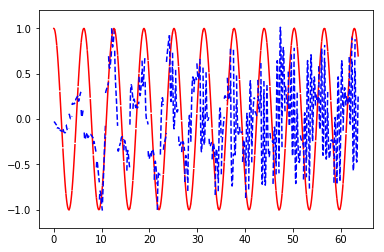

In [29]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 20
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

model = Sequential()
# build a LSTM RNN
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
    units=CELL_SIZE,
    return_sequences=True,      # True: output at all steps. False: output as last step.
    stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
))
# add output layer
model.add(TimeDistributed(Dense(OUTPUT_SIZE)))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse',)

print('Training ------------')
# plt.ion()
# plt.show()
for step in range(100):
    # data shape = (batch_num, steps, inputs/outputs)
    # X_batch shape (50, 20, 1)
    # Y_batch shape (50, 20, 1)
    X_batch, Y_batch, xs = get_batch()
    cost = model.train_on_batch(X_batch, Y_batch)
    pred = model.predict(X_batch, BATCH_SIZE)
    plt.plot(xs[0, :], Y_batch[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
    plt.ylim((-1.2, 1.2))
    plt.draw()
    plt.pause(0.1)
    if step % 20 == 0:
        print('train cost: ', cost)

In [15]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 20
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS))
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

In [18]:
X_batch, Y_batch, xs = get_batch()

In [23]:
Y_batch[0].flatten()

array([ 0.40808206, -0.54772926, -0.99996083, -0.53283302,  0.42417901,
        0.99120281,  0.64691932, -0.29213881, -0.96260587, -0.74805753,
        0.15425145,  0.91474236,  0.83422336, -0.01327675, -0.84857027,
       -0.90369221, -0.12796369,  0.76541405,  0.95507364,  0.26664293])

## [Traffic Prediction Using LSTM](http://www.yuthon.com/2016/10/30/Traffic-Prediction-Using-LSTM/)
- 数据集PeMS 2016.5.1-2016.10.26

In [4]:
import csv
from datetime import datetime
import numpy as np

def is_weekend(date):
    return int(date.weekday() in [5, 6])

def data_loader(filename):
    X = []
    y = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)  # 以字典的形式读入csv文件
        for row in reader:
            date = datetime.strptime(row['5 Minutes'], '%Y-%m-%d  %H:%M:%S')  # 时间序列
            X.append([date.weekday(), is_weekend(date), date.hour, date.minute])
            y.append([row['Mainline Agg']])
    X = np.array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1])  # X.shape=51552*1*4
    y = np.array(y)
    return X, y

def train_test_split(X, y, test_size=288):
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of rows")
    split_idx = X.shape[0] - test_size
    return X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:]

In [5]:
print('-- Loading Data --')
test_size = 1728
X, y = data_loader('sample_peme_data.csv')
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size)
print('Input shape:', X.shape)
print('Output shape:', y.shape)

-- Loading Data --
('Input shape:', (51552, 1, 4))
('Output shape:', (51552, 1))


In [7]:
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Sequential
from random import uniform

print('-- Creating Model--')
batch_size = 96
epochs = 100
out_neurons = 1
hidden_neurons = 500
hidden_inner_factor = uniform(0.1, 1.1)
hidden_neurons_inner = int(hidden_inner_factor * hidden_neurons)
dropout = uniform(0, 0.5)
dropout_inner = uniform(0, 1)

model = Sequential()
model.add(LSTM(units=hidden_neurons,
               input_shape=(None, X_train.shape[2]),
               kernel_initializer='uniform',
               return_sequences=True,))
model.add(Dropout(dropout))
model.add(LSTM(units=hidden_neurons_inner,
               return_sequences=True,))
model.add(Dropout(dropout_inner))
model.add(LSTM(units=hidden_neurons_inner,
               return_sequences=False,))
model.add(Dropout(dropout_inner))
model.add(Activation('relu'))
model.add(Dense(units=out_neurons,))
model.add(Activation('relu'))
model.compile(loss="mse",
              optimizer="adam",
              metrics=['accuracy'])

-- Creating Model--


In [ ]:
print('-- Training --')
history = model.fit(X_train,
                    y_train,
                    verbose=1,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=False)

-- Training --
Train on 44841 samples, validate on 4983 samples
Epoch 1/100
44841/44841 [==============================] - 28s - loss: 10.0677 - acc: 0.0024 - val_loss: 6.1337 - val_acc: 0.0012

In [40]:
from keras.models import Sequential
from keras.layers import LSTM

print('-- Creating Model--')

OUTPUT_SIZE = 1
BATCH_SIZE = 50
TIME_STEPS = 20
INPUT_SIZE = 1

model = Sequential()
# build a LSTM RNN
model.add(LSTM(batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE), 
               units=OUTPUT_SIZE, 
               return_sequences=True, 
               stateful=True,))

-- Creating Model--


In [1]:
(51.84-49.536)/51.84

0.04444444444444448